In [1]:
import numpy as np
from Bio import Entrez, SeqIO

In [2]:
# In order to import from the python file without hassle, we add the current
# directory to the python path
import sys; sys.path.append(".")

Let's let the nice folks at NCBI know who we are.

In [3]:
Entrez.email = "gl8689@fri.uni-lj.si"

# Phylogenetic analysis of coronaviruses

In the first part of the homework, we will conduct a phylogenetic analysis of a handful of coronaviruses. We will look at the similarity between the DNA sequences of these viruses to determine how closely related they are to one another. This might give us some insight into how these viruses might have evolved through time, or from which species SARS-CoV-2 jumped to us, humans.

We will build a phylogenetic tree in two steps. First, we will calculate the distances between each pair of viral genomes. We can't just compare them directly, we have to align them first. So we will run global alignment to get an optimal alignment between each pair of viral genomes. Then, we will calculate the distance between these alignments using Hamming distance. Hamming distance is defined as the number of symbols in the two sequences that do not match. Having calculated all pairwise distances, we can build a dendrogram, which will serve as our phylogenetic tree.

**A note on runtime:** To build a phylogenetic tree, you will need to calculate all pairwise distances between several coronavirus genomes. As you have learned in lectures, computing an alignment between two sequences of length $N$ and $M$ requires forming and calculating a table of $N \cdot M$ entries. This is fine for small sequences, but genomes, even short ones like viral genomes, are generally too long for this. For this reason, we will not calculate pairwise alignments between complete viral genomes in our analysis, but we will focus on the spike protein sequence only. The spike protein is one of the most important parts of any virus, as it is the one that grants the virus entry to host cells. Also, doing so will reduce the sequence lengths from ~30k to around 1.3k, which is much more manageable. Even so, do your best to write fast, efficient Python code, as you will spend a long time waiting for your programs to complete otherwise. I strongly suggest caching intermediate results e.g. pairwise alignments to disk to avoid having to recompute the same alignments multiple times.

In [4]:
accession_codes = {
    # 7 known human coronaviruses
    "Human-SARS-CoV-2": "NC_045512",
    "Human-SARS": "NC_004718",
    "Human-MERS": "NC_019843",
    "Human-HCoV-OC43": "NC_006213",
    "Human-HCoV-229E": "NC_002645",
    "Human-HCoV-NL63": "NC_005831",
    "Human-HCoV-HKU1": "NC_006577",
    
    # Bat
    "Bat-CoV MOP1": "EU420138",
    "Bat-CoV HKU8": "NC_010438",
    "Bat-CoV HKU2": "NC_009988",
    "Bat-CoV HKU5": "NC_009020",
    "Bat-CoV RaTG13": "MN996532",
    "Bat-CoV-ENT": "NC_003045",
    
    # Other animals
    "Hedgehog-CoV 2012-174/GER/2012": "NC_039207",
    "Pangolin-CoV MP789": "MT121216",
    "Rabbit-CoV HKU14": "NC_017083",
    "Duck-CoV isolate DK/GD/27/2014": "NC_048214",
    "Feline infectious peritonitis virus": "NC_002306",  # cat
    "Giraffe-CoV US/OH3/2003": "EF424623",
    "Murine-CoV MHV/BHKR_lab/USA/icA59_L94P/2012": "KF268338",  # mouse
    "Equine-CoV Obihiro12-2": "LC061274",  # horse
}

Here is the list of viruses and their accession codes that we will be working with in this homework. As mentioned in _a note on runtime_, we won't be using the entire sequence to infer phylogenies, but we'll only look at the spike protein sequence. To get spike protein regions from a `SeqRecord` object, we have to inspect the `features` field of each record. Look through the gene coding regions (CDS) of each sequence and find the region that codes for the "S" gene. Some records won't have this field, so look for "spike protein" in the `product` field.

In [5]:
# 1. load sequences
virus_sequences = {}

for name, code in accession_codes.items():
    with Entrez.efetch(db="nucleotide", id=code, rettype="gb") as handle:
        record = SeqIO.read(handle, "genbank")
    
    virus_sequences[name] = record

In [6]:
# 2. extract spike protein regions
virus_spike_proteins = {}

for virus, record in virus_sequences.items():
    for feature in record.features:
        if feature.type != 'CDS':
            continue
            
        if 'product' in feature.qualifiers and feature.qualifiers.get('product')[0] == 'spike protein':
            virus_spike_proteins[virus] = feature
        elif 'gene' in feature.qualifiers and feature.qualifiers.get('gene')[0] == 'S':
            virus_spike_proteins[virus] = feature

In [7]:
# 3. convert to amino-acid sequences
virus_amino_acids = {}

for virus, spike_protein in virus_spike_proteins.items():
    virus_amino_acids[virus] = virus_spike_proteins[virus].translate(virus_sequences[virus])

## Problem 1: Global alignment

**TASK:**
Implement the Needleman-Wunsch algorithm you learned about in lectures for global sequence alignment in the `global_alignment` functions in `helper_functions.py`. Indels should be denoted using the "-" character. **[10 points]**

In [8]:
from helper_functions import global_alignment, scoring_function_blosom, hamming_distance
import numpy as np

In [9]:
print(global_alignment("the brown cat", "these brownies", lambda x, y: [-1, 1][x == y]))

('the-- brown cat', 'these brownies-', 3.0)


## Problem 2: Coronavirus phylogeny

**TASK:**
Build a phylogenetic tree using the `global_alignment` function you implemented in the previous section. You will first need to calculate distances between all pairs of protein sequences. To calculate the distance between two sequences, first, calculate the global alignment of the two sequences. Then, compare these alignments using Hamming distance. The Hamming distance is just the number of mismatching characters between the two sequences e.g. the Hamming distance between "cat" and "hat" is 1, or 3 between "road" and "rain". Note that this distance is different from the global alignment score produced by `global_alignment`! Once you have calculated all pairwise distances, plot the dendrogram. Apply what you learned about hierarchical clustering in other machine learning courses to get as nice a dendrogram as possible. If you have not taken any machine learning courses, the recommendation is to not use *single linkage*. Save the resulting dendrogram into `problem2.png`. Are the results surprising? Do you see something you didn't expect? Save your answers into the `phylogeny_comments` variable. **[10 points]**

Hint: check out `scipy.spatial.distance.squareform`, `scipy.cluster.hierarchy.linkage`, and `scipy.cluster.hierarchy.dendrogram` to build and plot the dendrogram.

You will also need to define a scoring function for sequence alignment. Use BLOSUM62 throughout this homework. You can use `biopython` for this. Please note that biopython uses the "*" character for indels, while we are using "-". To be consistent with the lectures, your implementation must use "-". However, you can easily replace all the "-" characters with "*" if you want to use the BLOSUM62 matrix from biopython.

In [59]:
distance_matrix = np.zeros((len(virus_spike_proteins.keys()), len(virus_spike_proteins.keys())))

for i, (virus, record) in enumerate(virus_spike_proteins.items()):
    for j, (virus2, record2) in enumerate(virus_spike_proteins.items()):
        if virus == virus2 or distance_matrix[j][i] != 0:
            continue
            
        protein1 = record.qualifiers['translation'][0]
        protein2 = record2.qualifiers['translation'][0]
            
        align1, align2, score = global_alignment(protein1, protein2, scoring_function_blosom)
        distance_matrix[i][j] = hamming_distance(list(align1), list(align2))

14 15 962.0
14 16 902.0
14 17 1071.0
14 18 966.0
14 19 920.0
14 20 963.0000000000001
15 16 876.0
15 17 1084.0
15 18 82.0
15 19 491.99999999999994
15 20 255.0
16 17 1017.0
16 18 998.0000000000001
16 19 968.0000000000001
16 20 996.0000000000001
17 18 1075.0
17 19 1038.0
17 20 1083.0
18 19 487.0
18 20 250.0
19 20 498.0


In [62]:
distance_matrix = [[   0.,  301.,  930.,  954.,  913., 1017.,  970., 1033., 1018.,
         890.,  911.,   33.,  958.,  930.,  126.,  954.,  863., 1074.,
         961.,  930.,  962.],
       [   0.,    0.,  927.,  947.,  912., 1014.,  967., 1031., 1018.,
         889.,  909.,  295.,  954.,  912.,  305.,  950.,  913., 1069.,
         949.,  931.,  954.],
       [   0.,    0.,    0.,  949.,  867., 1053.,  956., 1037., 1048.,
         874.,  489.,  931.,  958.,  589.,  895.,  953.,  929., 1072.,
         963.,  939.,  962.],
       [   0.,    0.,    0.,    0.,  887., 1036.,  501., 1062., 1053.,
         852.,  968.,  957.,  113.,  945.,  952.,  124.,  882., 1076.,
         113.,  497.,  281.],
       [   0.,    0.,    0.,    0.,    0.,  586.,  997.,  807.,  780.,
         865.,  988.,  937., 1007.,  977.,  936., 1002.,  821.,  861.,
        1001.,  973.,  998.],
       [   0.,    0.,    0.,    0.,    0.,    0., 1034.,  773.,  751.,
         861., 1046.,  999., 1049., 1033.,  956., 1051.,  827.,  835.,
        1047., 1051., 1040.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0., 1030., 1066.,
         860.,  995.,  971.,  487.,  954.,  977.,  492.,  874., 1081.,
         486.,  524.,  487.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  736.,
         879., 1009.,  975., 1037., 1004.,  981., 1045.,  835.,  874.,
        1038., 1055., 1037.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         870., 1051.,  939., 1057., 1034.,  946., 1063.,  831.,  824.,
        1053., 1038., 1061.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,  997.,  937., 1005.,  975.,  926.,  992.,  890., 1070.,
        1000.,  969., 1005.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,  880.,  969.,  583.,  867.,  968.,  906., 1074.,
         964.,  939.,  970.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,  958.,  926.,  135.,  959.,  885., 1071.,
         961.,  928.,  963.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,  944.,  955.,   81.,  855., 1081.,
          15.,  494.,  252.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,  930.,  954.,  905., 1073.,
         935.,  925.,  962.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,  962.,  902., 1071.,
         966.,  920.,  963.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,  876., 1084.,
          82.,  492.,  255.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0., 1017.,
         998.,  968.,  996.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1075., 1038., 1083.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,  487.,  250.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,  498.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.]]

In [63]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

distance_matrix = np.array(distance_matrix)
distance_matrix = distance_matrix + distance_matrix.T - np.diag(np.diag(distance_matrix))
np.array(distance_matrix)

array([[   0.,  301.,  930.,  954.,  913., 1017.,  970., 1033., 1018.,
         890.,  911.,   33.,  958.,  930.,  126.,  954.,  863., 1074.,
         961.,  930.,  962.],
       [ 301.,    0.,  927.,  947.,  912., 1014.,  967., 1031., 1018.,
         889.,  909.,  295.,  954.,  912.,  305.,  950.,  913., 1069.,
         949.,  931.,  954.],
       [ 930.,  927.,    0.,  949.,  867., 1053.,  956., 1037., 1048.,
         874.,  489.,  931.,  958.,  589.,  895.,  953.,  929., 1072.,
         963.,  939.,  962.],
       [ 954.,  947.,  949.,    0.,  887., 1036.,  501., 1062., 1053.,
         852.,  968.,  957.,  113.,  945.,  952.,  124.,  882., 1076.,
         113.,  497.,  281.],
       [ 913.,  912.,  867.,  887.,    0.,  586.,  997.,  807.,  780.,
         865.,  988.,  937., 1007.,  977.,  936., 1002.,  821.,  861.,
        1001.,  973.,  998.],
       [1017., 1014., 1053., 1036.,  586.,    0., 1034.,  773.,  751.,
         861., 1046.,  999., 1049., 1033.,  956., 1051.,  827.,  835.

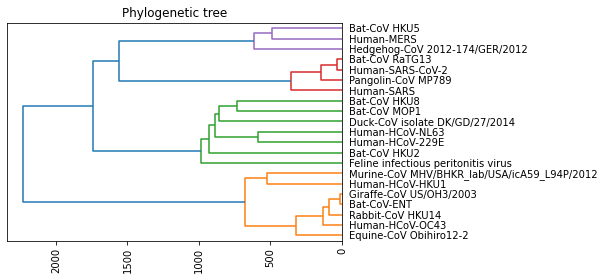

In [65]:
phylogeny_comments = """
Before I ploted the dendrogram I thought that Human coronaviruses will be closely related which seems to not
be the case. As expected Human-Sars and Human-Sars-Cov-2 are closely related. Also what I find interesting is that
bats coronaviruses are related to other coronaviruses of species. Also it is interesting that the most related too
Sars-CoV-2 are coronaviruses from bats and pangolins.
"""

dist = squareform(distance_matrix)
linkage_matrix = linkage(dist, "ward")
dendrogram(linkage_matrix, labels=[label for label, _ in virus_spike_proteins.items()], orientation='left')
plt.xticks(rotation=90)
plt.title("Phylogenetic tree")
plt.show()

# MiniBLAST

In the previous homework, your task was to find ORF candidates, which we then ran through NCBI's BLAST to find matching sequences in other organisms. Doing so, we were able to determine whether each ORF is a gene, and if it is a gene - what that gene does. In this homework, we will implement our own simplified version of BLAST, MiniBLAST.

*Disclaimer*: Obviously, BLAST is a complicated, state-of-the-art piece of technology, and the algorithms we will use here are not used in NCBI's BLAST at all. BLAST is highly optimized and uses heuristics to obtain (very good) approximate solutions and can query thousands of sequences in a matter of seconds. Our implementation will be slightly less sophisticated and slightly slower. However, the basic functionality and end result of this implementation will be conceptually the same as that of BLAST.

## Problem 3: Local alignment

**TASK:**
Implement the Smith-Waterman algorithm you learned about in lectures for local sequence alignment in the `local_alignment` function in `helper_functions.py`. Indels should be denoted using the "-" character. **[10 points]**

In [11]:
from helper_functions import local_alignment

print(local_alignment("the brown cat", "these brownies", lambda x, y: [-1, 1][x == y]))

('the-- brown', 'these brown', 7.0)


## Problem 4: Finding homologoues

In the previous homework, we found ORF candidates in the SARS-CoV-2 genome and applied some filtering to reduce the number of ORFs we have to check. We then used NCBI's BLAST to find similar sequences in other organisms, which have already been annotated. We were then able to infer whether or not our ORF candidates were genes, and if they were, what they do. We would like to go through this process again, but this time, everyone from NCBI decided to go on a yearlong cruise around the world, and their servers just happened to go down with nobody to fix them. So we are left to fend for ourselves.

We have already run our ORF finder and, having applied some clever filtering, we have managed to narrow down our search to five ORFs. We will use our MiniBLAST implementation to test each of these ORFs to known, annotated sequences from three known coronaviruses, hoping to find a good match. A good match would mean that our ORF is most likely a gene, and since we know what the gene does in the reference virus, we will assume it does the same in SARS-CoV-2.

**TASK:**
We randomly pick three viruses -- Human-SARS, Bat-CoV RaTG13, and Pangolin-CoV MP789 -- to use as reference genomes. We are given 5 ORFs from SARS-CoV-2 that we found in the previous homework. It is our job to determine their function i.e. what gene they code for. For each ORF, calculate the local alignment to all annotated protein sequences from the three reference genomes. Score each alignment by counting the number of matching symbols in the aligned sequences e.g. A-TT and A-GG has similarity 2 (similarily to Hamming distance, but reversed).

Save your answers into the `orf_matches` variable as indicated in the cell below. Each ORF should be assigned a *closest-organism*, indicating in which reference virus the closest match was found, as well as a *homologous-gene*, indicating which gene the ORF matched to. Note any interesting observations into the `orf_comments` variable.
**[10 points]**

In [40]:
reference_genomes = [
    "Human-SARS",
    "Bat-CoV RaTG13",
    "Pangolin-CoV MP789",
]
query = "Human-SARS-CoV-2"

We first have to build up our reference database. To do this, look through all the coding regions (CDS) on each reference genome, extract it, and convert it to a protein sequence. Remember which gene each protein sequence belongs to, e.g. ORF1a, spike protein, ...

Here are the ORF candidates from SARS-CoV-2:

In [41]:
orf_candidates = {
    "ORF-1": (1, 11995, 13483),
    "ORF-2": (1, 26792, 27191),
    "ORF-3": (1, 23650, 25384),
    "ORF-4": (1, 9133, 13483),
    "ORF-5": (1, 25392, 26220),
}

In [51]:
virus_translations = {}

#All translations from CDS for reference genomes
for virus, record in virus_sequences.items():
    if virus not in reference_genomes:
        continue
    
    for feature in record.features:
        if feature.type != 'CDS':
            continue
            
        if virus not in virus_translations:
            virus_translations[virus] = [(feature.qualifiers['product'][0], feature.qualifiers['translation'][0])]
        else:
            virus_translations[virus].append(((feature.qualifiers['product'][0], feature.qualifiers['translation'][0])))
            
virus_translations

{'Human-SARS': [('ORF1ab polyprotein',
   'MESLVLGVNEKTHVQLSLPVLQVRDVLVRGFGDSVEEALSEAREHLKNGTCGLVELEKGVLPQLEQPYVFIKRSDALSTNHGHKVVELVAEMDGIQYGRSGITLGVLVPHVGETPIAYRNVLLRKNGNKGAGGHSYGIDLKSYDLGDELGTDPIEDYEQNWNTKHGSGALRELTRELNGGAVTRYVDNNFCGPDGYPLDCIKDFLARAGKSMCTLSEQLDYIESKRGVYCCRDHEHEIAWFTERSDKSYEHQTPFEIKSAKKFDTFKGECPKFVFPLNSKVKVIQPRVEKKKTEGFMGRIRSVYPVASPQECNNMHLSTLMKCNHCDEVSWQTCDFLKATCEHCGTENLVIEGPTTCGYLPTNAVVKMPCPACQDPEIGPEHSVADYHNHSNIETRLRKGGRTRCFGGCVFAYVGCYNKRAYWVPRASADIGSGHTGITGDNVETLNEDLLEILSRERVNINIVGDFHLNEEVAIILASFSASTSAFIDTIKSLDYKSFKTIVESCGNYKVTKGKPVKGAWNIGQQRSVLTPLCGFPSQAAGVIRSIFARTLDAANHSIPDLQRAAVTILDGISEQSLRLVDAMVYTSDLLTNSVIIMAYVTGGLVQQTSQWLSNLLGTTVEKLRPIFEWIEAKLSAGVEFLKDAWEILKFLITGVFDIVKGQIQVASDNIKDCVKCFIDVVNKALEMCIDQVTIAGAKLRSLNLGEVFIAQSKGLYRQCIRGKEQLQLLMPLKAPKEVTFLEGDSHDTVLTSEEVVLKNGELEALETPVDSFTNGAIVGTPVCVNGLMLLEIKDKEQYCALSPGLLATNNVFRLKGGAPIKGVTFGEDTVWEVQGYKNVRITFELDERVDKVLNEKCSVYTVESGTEVTEFACVVAEAVVKTLQPVSDLLTNMGIDLDEWSVATFYLFDDAGEENFSSRMYCSFYPPDEEEEDDAECEEEEIDETCEHEYGTEDDY

In [57]:
def reverse_hamming_distance(align1, align2):
    count = 0
    
    for i in range(len(align1)):
        if align1[i] == align2[i]:
            count += 1
            
    return count

for orf_candidate, orf in orf_candidates.items():
    covid_orf_sequence = str(virus_sequences[query].seq[orf[1]:orf[2]].translate(stop_symbol=""))
    
    for genome, sequences in virus_translations.items():
        max_value = ('', 0)
        
        for product, translation in sequences:   
            reference_genome_sequence = str(translation)
            align1, align2, _ = local_alignment(covid_orf_sequence, reference_genome_sequence, scoring_function_blosom)

            if reverse_hamming_distance(align1, align2) > max_value[1]:
                max_value = (product, reverse_hamming_distance(align1, align2))
                
        print(orf_candidate, genome, max_value[0], max_value[1])

ORF-1 Human-SARS ORF1a polyprotein 480
ORF-1 Bat-CoV RaTG13 orf1ab polyprotein 491
ORF-1 Pangolin-CoV MP789 orf1ab polyprotein 491
ORF-2 Human-SARS membrane glycoprotein M 120
ORF-2 Bat-CoV RaTG13 membrane protein 132
ORF-2 Pangolin-CoV MP789 membrane glycoprotein 132
ORF-3 Human-SARS spike glycoprotein 523
ORF-3 Bat-CoV RaTG13 spike glycoprotein 575
ORF-3 Pangolin-CoV MP789 surface glycoprotein 570
ORF-4 Human-SARS ORF1a polyprotein 1335
ORF-4 Bat-CoV RaTG13 orf1ab polyprotein 1440
ORF-4 Pangolin-CoV MP789 orf1ab polyprotein 1436
ORF-5 Human-SARS ORF3a protein 203
ORF-5 Bat-CoV RaTG13 nonstructural protein NS3 269
ORF-5 Pangolin-CoV MP789 ORF3 protein 267


In [13]:
orf_matches = {
    "ORF-1": {
        "closest-organism": "Bat-CoV RaTG13, Pangolin-CoV MP789", 
        "homologous-gene": "orf1ab polyprotein",
    },
    "ORF-2": {
        "closest-organism": "Bat-CoV RaTG13, Pangolin-CoV MP789",
        "homologous-gene": "membrane protein, membrane glycoprotein",
    },
    "ORF-3": {
        "closest-organism": "Bat-CoV RaTG13",
        "homologous-gene": "spike glycoprotein",
    },
    "ORF-4": {
        "closest-organism": "Bat-CoV RaTG13",
        "homologous-gene": "orf1ab polyprotein",
    },
    "ORF-5": {
        "closest-organism": "Bat-CoV RaTG13",
        "homologous-gene": "nonstructural protein NS3",
    },
}
orf_comments = """
What I find interesting is that Bat-CoV RaTG13 is the most related to Sars-CoV-2. Another closely related is Pangolin-CoV MP789
and in some cases they have the same reverse hamming distance score. It is also interesting that in case of ORF-2
Bat-CoV RaTG13 and Pangolin-CoV MP789 have the same score but for diffrent parts of their genome.
"""

## Bonus Problem: Finding homologues with (slightly more) distant viruses

In the previous problem, we saw that we were able to find very good matches for each of our ORFs. This is because our reference genomes were very closely related to SARS-CoV-2 (refer to the phylogenetic tree from problem 2). In this exercise, we will check if we can still recover the ORF identities, the same as in Problem 4, using three less-related reference genomes: Human-MERS, Bat-CoV HKU5, and Hedgehog-CoV 2012-174/GER/2012. Report your predictions in the `orf_bonus_matches` variable. Additionally, you should report how confident you are in each prediction. Use your creativity to score your confidence in each alignment. Write your justifications and other observations to the `orf_bonus_comments` variable.
**[5 points]**

In [ ]:
reference_genomes = [
    "Human-MERS",
    "Bat-CoV HKU5",
    "Hedgehog-CoV 2012-174/GER/2012",
]
query = "Human-SARS-CoV-2"

In [ ]:
orf_bonus_matches = {
    "ORF-1": {
        # These are just example solutions. You have to replace them with the correct answers
        "closest-organism": "Duck-CoV isolate DK/GD/27/2014", 
        "homologous-gene": "non-structural protein",
        "confidence": 3  # not confident: 1 -- 5 : completely confident
    },
    "ORF-2": {
        "closest-organism": "TODO",
        "homologous-gene": "TODO",
        "confidence": -1
    },
    "ORF-3": {
        "closest-organism": "TODO",
        "homologous-gene": "TODO",
        "confidence": -1
    },
    "ORF-4": {
        "closest-organism": "TODO",
        "homologous-gene": "TODO",
        "confidence": -1
    },
    "ORF-5": {
        "closest-organism": "TODO",
        "homologous-gene": "TODO",
        "confidence": -1
    },
}
orf_bonus_comments = """
Did you notice anything interesting?
"""

## Bonus problem: Recombination

We tend to think of evolution as a hierarchical process: we have some common ancestor which split into several sub-species through a series of random mutations. However, nothing ever really is that straightforward in biology. There have been well documented cases of horizontal gene transfer in nature where organisms swap entire chunks of DNA with each other. In viruses, something similar can happen as well. When a cell is infected with multiple viruses (potentially coming from different strains), a *recombination event* can occur. Recombination occurs when the DNA is being copied, but, for some reason, the copying machine swaps out the virus that is being copied. For instance, we could start copying virus A, then midway, the copier will switch to virus B, effectively resulting in new virus DNA which has DNA from both viruses A and B.

During the start of the global pandemic, there was much confusion about the origins of SARS-CoV-2. It was initially thought to come from bats. Then, at some point, people noticed that a critical piece of the spike protein -- the receptor binding domain (RBD) -- was more similar to the sequence of pangolin coronaviruses. This evidence points to recombination. At some point, before the virus jumped to humans, there must have been some host infected with both the Bat RaTG13 coronavirus and the Pangolin coronavirus where this recombination took place.

In this problem, we will look at the spike protein, and look at the receptor binding domain, and check this evidence for recombination ourselves.

**TASK**:
Take the spike proteins of the three viruses in question and align the sequences with each other. Since we're comparing the differences of the bat and pangolin coronaviruses to humans, we only need to align human to bat and human to pangolin, and compare the differences in alignments. Find the the RBD of SARS-CoV-2 (the NCBI graphical view of the SARS-CoV-2 genome might be helpful here) and look at the aminoacid mismatch rate inside the RBD vs the outside. Which coronavirus is more similar to SARS-CoV-2 in the RBD, and which is more similar outside the RBD? Create a visualization of your choice that compares the human to bat vs. the human to pangolin alignment. You can look at Fig. 2a from [the original Nature paper](https://www.nature.com/articles/s41586-020-2169-0) for one possible visualization direction. Save your visualization to `recombination.png` and write down the mismatch rates and your comments/findings into `recombination_comments`.
**[5 points]**

Here are some things you may want to think about. If we know recombination events occur in viruses, do phylogenetic trees like the one we made in Problem 2 make sense? Looking at your visualization, does there seem to be any other regions in the spike gene (or elsewhere in the genome) that could possibly be due to recombination? Could there be any alternative explanation for regions of large differences?

In [ ]:
recombination_comments = """
"""